## Quick Abc to midi converter
- http://www.mandolintab.net/abcconverter.php


## Major and Minor
- https://www.youtube.com/watch?v=fKpUBsn_jmA
- help create mood and atmossphere of music

In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
BATCH_SIZE = 16
N_GRAM = 64
MODEL_DIR = './music_model/04_21_19_LayersGeneric_transfer_256_128_classical_cleaned_small_batchsize20_window30/'
# MODEL_DIR = './music_model/04_22_19_BindirectionalLayersGeneric_TRANSFER_256_128_jig_horn_cleaned_small_batchsize20_window30/'
# MODEL_DIR = ''
# MODEL_DIR = './music_model/04_20_19_LayersRNNGeneric_256_128_classical_fixed_activation_batchsize8000/'
# MODEL_DIR = './music_model/04_20_19_LayersRNNGeneric_256_128_jig_hog_fixed_activation_batchsize16/'#good model
DATA_PATH = './data/jig_hornpipes_cleaned.txt'
MODEL_TYPE = 'Default'#unuse for now
BATCH_SIZE = 1
starting = '''[a2D2F,2][f2D,2]'''
SEQ_LENGTH = len(starting)

In [3]:
with open(os.path.join(MODEL_DIR, 'model_dictionary.json')) as f:
    vocab_map = json.load(f)

n_vocab = len(vocab_map['idx2char'])

print('n_vocab', n_vocab)

n_vocab 34


In [4]:
from models import MusicModel
# model = MusicModel(n_vocab).TwoLayerLSTM(batch_input_shape=(BATCH_SIZE, 1))
# model = MusicModel(n_vocab).TwoLayerLSTM(batch_input_shape=(BATCH_SIZE, SEQ_LENGTH))

model = MusicModel(n_vocab, 'test').LayersRNNGeneric(batch_input_shape=(BATCH_SIZE, SEQ_LENGTH),
                                            layers=['lstm', 'lstm'], 
                                             layers_size=[256, 128],
                                             emb_dim=512,
                                             drop_rate=0.15)
# model = MusicModel(n_vocab, phase='test').BidirectionalLayersRNNGeneric(batch_input_shape=(BATCH_SIZE, SEQ_LENGTH),
#                                                     layers=['lstm','lstm'], 
#                                                      emb_dim=256,
#                                                      layers_size=[256, 128], drop_rate=0.6)

# model = MusicModel(n_vocab).LSTMSkipConnection(batch_input_shape=(BATCH_SIZE, SEQ_LENGTH),
# #                                                                 layers=[128, 256, 128],
#                                                                layers = [128,256,128],
#                                                                 emb_dim=256,drop_rate=0.35)

# model = MusicModel(n_vocab, phase='test').ResidualLSTM(batch_input_shape=(BATCH_SIZE, SEQ_LENGTH),
#                                         rnn_width=128,
#                                         rnn_depth=5,
#                                         drop_rate=0.15)

# model = MusicModel(n_vocab).LSTMSkipConnectionDropBetween(batch_input_shape=(BATCH_SIZE, SEQ_LENGTH),
#             layers=[256, 256], 
#             emb_dim=356, drop_rate=0.15)
    
# model = MusicModel(n_vocab).LSTMSkipConnection(batch_input_shape=(BATCH_SIZE, SEQ_LENGTH),
# #                     layers=[128, 256, 128],
#                     layers = [256],
#                     emb_dim=256,drop_rate=0.3)
print('\n',model.summary())


Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (1, 16, 512)              17408     
_________________________________________________________________
lstm_0_256 (LSTM)            (1, 16, 256)              787456    
_________________________________________________________________
drop_0 (Dropout)             (1, 16, 256)              0         
_________________________________________________________________
lstm_1_128 (LSTM)            (1, 128)                  197120    
_________________________________________________________________
drop_1 (Dropout)             (1, 128)                  0         
_________________________________________________________________
dense_1 (Dense)              (1, 34)                   4386      
_________________________________________________________________
activation_1 (Activation)    (1, 34)                   0         
Total para

In [5]:
from keras.utils import plot_model
plot_model(model, to_file='test.png')

In [6]:
model.load_weights(MODEL_DIR+'/model_weight/'+"Weights_{}.h5".format(40)) #by_name=True

In [7]:
display(vocab_map['idx2char'])

{'0': '[',
 '1': '6',
 '2': '^',
 '3': '1',
 '4': 'a',
 '5': 'C',
 '6': 'g',
 '7': 'd',
 '8': ']',
 '9': '\\',
 '10': 'c',
 '11': 'D',
 '12': '\n',
 '13': ',',
 '14': '2',
 '15': '|',
 '16': '9',
 '17': '7',
 '18': '5',
 '19': 'E',
 '20': 'G',
 '21': '3',
 '22': ' ',
 '23': 'b',
 '24': '>',
 '25': '<',
 '26': '_',
 '27': 'F',
 '28': '4',
 '29': '8',
 '30': 'A',
 '31': 'f',
 '32': 'e',
 '33': 'B'}

In [20]:
len(starting)

16

In [9]:


def generate_sequence_seq_as_inp(model, vocab_map, seq_length=300,starting='''"D7"A^GA DFA''', return_heatmap=False):
    if return_heatmap: heat_map = np.zeros(shape=(2, 5+1, seq_length))# 1: idx, 2: is the probility of that index
    sequence_index = [int(vocab_map['char2idx'][c]) for c in starting]
    seq_len = len(starting)
    n_vocab = len(vocab_map['idx2char'])
    for i in range(seq_length-seq_len):
        batch = np.zeros((1, seq_len))
        batch[0] = sequence_index[-seq_len:]
        predicted_probs = model.predict_on_batch(batch).ravel()
#         print(predicted_probs.shape)
        sample = np.random.choice(range(n_vocab), size = 1, p = predicted_probs)[0]
        sequence_index.append(sample)
#         print(sorted(predicted_probs, reverse=True)[:10])
        
        if return_heatmap:
            heat_map[0,0,i] = sample
            heat_map[1,0,i] = predicted_probs[sample]
            heat_map[0,1:,i] = sorted_idx = np.argsort(predicted_probs)[-5:][::-1].astype(int)#reversed
            heat_map[1,1:,i] = predicted_probs[sorted_idx]
    str_seq = seq = ''.join(vocab_map['idx2char'][str(c)] for c in sequence_index)
    
    #postprocessing here
    if return_heatmap:
        return str_seq, heat_map
    else: return str_seq
    
def generate_sequence(model, vocab_map, initial_index=0, seq_length=300, return_heatmap=False):
    
    if return_heatmap: heat_map = np.zeros(shape=(2, 5+1, seq_length))# 1: idx, 2: is the probility of that index
    
    
    sequence_index = [initial_index]
    n_vocab = len(vocab_map['idx2char'])
    prev_note = '\n'
    stop_note = ['\n', '%', ']', '[', ' ']
    for i in range(seq_length):
        batch = np.zeros((1, 1))
        batch[0, 0] = sequence_index[-1]
#         print(batch)
        predicted_probs = model.predict_on_batch(batch)[-1].ravel()
        sample = np.random.choice(range(n_vocab), size = 1, p = predicted_probs)[0]
#         sample = np.argmax(predicted_probs)
        if return_heatmap:
            heat_map[0,0,i] = sample
            heat_map[1,0,i] = predicted_probs[sample]
            heat_map[0,1:,i] = sorted_idx = np.argsort(predicted_probs)[-5:][::-1].astype(int)#reversed
            heat_map[1,1:,i] = predicted_probs[sorted_idx]
#         print(sorted_idx)
#         heat_map[np.argsort(predicted_probs)]
#         print(predicted_probs)
#         sample = np.argmax(predicted_probs)
#         print(predicted_probs)
#         print(predicted_probs)
#         while vocab_map['idx2char'][str(sample[0])] in ['\n', '%']:
#         print(sample[0])
#         if  vocab_map['idx2char'][str(sample[0])] in ['\n','%', '\\']:
#             continue
#         while vocab_map['idx2char'][str(sample[0])] in stop_note and prev_note in stop_note:
#             sample = np.random.choice(range(n_vocab), size = 1, p = predicted_probs)
#         print(predicted_probs)
#         print(sample[0])

        prev_note = vocab_map['idx2char'][str(sample)]
        sequence_index.append(sample) 
    
    str_seq = seq = ''.join(vocab_map['idx2char'][str(c)] for c in sequence_index)
    
    #postprocessing here
    if return_heatmap:
        return str_seq, heat_map
    else: return str_seq
    

A, G^GF|"D"DFF "A7"ecA|"A"A2e ecA|"Bm"e2d "B7"d2f|"A"eed cea|"D"agd "D"F2:|
P:B
c/2G/2|"D"E^FE a2A|"A/f+"c2^c "G"B2d|"D"def aed|"C"e2e cAG|"Em"B2A GBc|"D"F3 A3|
"G"B2B B2||


d/2e/2|"F7"fed "A7"c3|"Am"EcA "A7"GGA|
"G"BcB "C7"e2e|"Bm"ded def|"G"d3 "D7"FAF|
"D"a2a f2e|"A7"BcA AB,|"D7"D2, D2:|
P:B
g|"D"

In [15]:
gen, heatmap = generate_sequence_seq_as_inp(model, vocab_map, seq_length=1000,starting=starting, return_heatmap=True)
print(gen)

[a2D2F,2][f2D,2] | e[f2^G2G,2]B [f2A2][e2G2] | [f2A2D2][e2^C2] | f[e2G2]fg [f2A,2]a[gB] | fa5g[fd]e d5^cB[e2c2] |A,2f[e2B,2] ^f[b2C2] | D[g2C2]F, |
[d2B,,2]>E,2 [g2B2G,2]>G,2 | [c2B2A,2]>G,2 [A2E2C2A,2] |
G2>[B2^C2] [GB]FEF |
[G_E]BAG [f2D2]g2 |
f2e2 [d2C2]e2 | f2B2 d2^c2 |d2[e2G2]f efg[a2D2] ga[b2D2] |
^C2[f2D2]e2[e2E2] |
B,2[^c2A,2] d[g2B,2]F, | _E,dD,[e2^C,2]A,, | fgB[e2C,2]^F,2d |
b[b2D,2]^C,2[fD,] | 3e2d2c2 3E,2D,2^C, |
D,^C,E,_E, [DF,]E,D,C | DG^FE
F2G,,2 [F2B2A,2D,2][G2E,2] | [d2A,2F,2]^c2 [_e2E2^c2][c2E,2] |
F,,2[g2G,,2] [^G2F,2][B2_E,2] |
[D2^F,2] C2B,2 | C4 [G2B,2]A,2 | [D2B,2G,2] [C4A,4] | B,4 [D4A,4] ^G,4 | [e4D4F,4] G,2[D4E4] | [F4A4C4] _B,4 | [c4F4A,4]>G,4 | [c4F,4D,4] B,,4 | [e^F4F,,4] B4 | [G4_E,4E,4] B,4 | ^G,2^F,2 G,4e | A,1F, |
[f4G4B,4]>[g4C4] | [f4D4F,4] F,2G, | [A4A,4F,4] ^F,4[BG,E,]G, | [AF,F,]Bc^FG,> | A,4 D,2^G,4 |
F,4 E,4 F,2G,2 | [F4D4A,4F,4] [G,4E4] | [D4F4C,4A,4] E4 | [G4D4^F,4A,4]>E4 | [B4^F,4] G,4 [d6A,6] |
[F4G,4G,4] [E4G4B,4] |
[F4C4] [A4G44] |
B,4 [^G4

In [13]:
print(gen)

"D7"A^GA DFADtAA|GG DFA|AAA|"G
"AA"AAA|"GG"A7 AcB|"GG"A"eAAA-"GG"B"AAAAGcGG"G"AAAAGBGG|A"AAAAGBGG|
"Ac"BGAGG|
"AB"BG GG|
"AB2B GGG|
"AB2B GGG|
"AB2 dGGG|G"GBd GGcF|
"GBdG GFA||"GBd DGFA|
"Gdd 3FF:|
"G/:e/:a



/6::/:





:::::


PFP:::
3K::Mu)P:

::::K8
P


P:::\:



PP:C:
::


:::PP


:

P::6:

|P:
P:::

:/:::.:3PABBPPP::]VBBEF4K1>aAzM!lIhuFuoiD7u-h]:['v0Vl%Pp]!9\I1%[Ks~pnvs0oIS%s0Cznhr%!88u>s%t


In [25]:
import random
initial_index = np.random.randint(0, n_vocab, size=(1,))[0]
music_abc, heatmap = generate_sequence(model, vocab_map, initial_index=initial_index, seq_length=1000, return_heatmap=True)
# /**/
print(music_abc)

%"D"cB3 "Am"a2ee/2e|"E "G3| d d3E^d2B d\

P:|"A2A3 "^d|"d|"C"c3 "g/2dd dc3 "g|"D"A ""E c+"D"D"fagdB3 "E7"G"c|
P:B|"D"ab9Ia2d|"F|"af+"G2f/4|B3/2:|
P:|\
B,Em"d|"C"AB7"GF3:|"ABMm"DEm"A"cBd2d2A"Ag ^f3 e3 G" f|"fedgf|D"AB "B2d "G|"D"C"CP:C"de3Em"C"dg|"cdbae|"GFGB
"ag||\
P:F3 "A/2Em"f|"A|"A "C"ed2BABm"d2edef|"G"D"G"d|"C"C"B,C"=cdBm"GFA"D"df3 -Ac/2d|"addBc/2b2B,BB|"Em"A2aga2:B2e|"de|de "B|"A6|"DF|


a BA d||e|

d/2-"ABcB B|"G d|

P:|ce|[2a de|"GEm"F|"DFG edgb2cB2a2AG3ce|"D|"d "D"D"g/2GBcB2d "ed|
P:|"ded| fef Cd c/2agB ed2"d2BA"G"A/2cAG3 Am"B Bc3 "A g2A "agf|"C"b "Am"C"e "G3 dBBcAF|
"fae2e3|

d|:|

"d|\
"B
"D/2|
"D"Em"ecBcG A|
ag|"D "d|
BcBm"D"E d|"D c\
P:t

"D3 ABce|"GA2efe|"(1ag|"D"D7"G"F"f|"f2a3 "D7"c3/2a "GF|A2B
P:|"a3 Bm"A/2d -ded-dc|"d "f2fee||B "d -Bc3 d c|
A GABGF#!"D B2FP:A"Em"FG"agbaefe2"Em"D7"D"G d|"e/2ga2cAc|"G "G3 aga2B2B gfaf|"f|"gfe d3 "=cB7"F| d cd3 "Az2ag|
B7"G7"a2BA""D "Bc'b2G f||
"GF|"dcBc|"E|d2A"e2ag|"^d "Agfa3 -fe|"G|

"ddBc c'3|"GFG "D"A"d2a2fed d^dcedf2AB3 g|d2efed2fd2e|

In [15]:
print(heatmap[1, :3])

[[ 0.01541017  0.01494989  0.01602851 ...,  0.01488989  0.0199335
   0.01592204]
 [ 0.0162839   0.0165707   0.01745183 ...,  0.01685495  0.02203951
   0.01638138]
 [ 0.01616734  0.01641496  0.01719277 ...,  0.01679535  0.0199335
   0.01619886]]


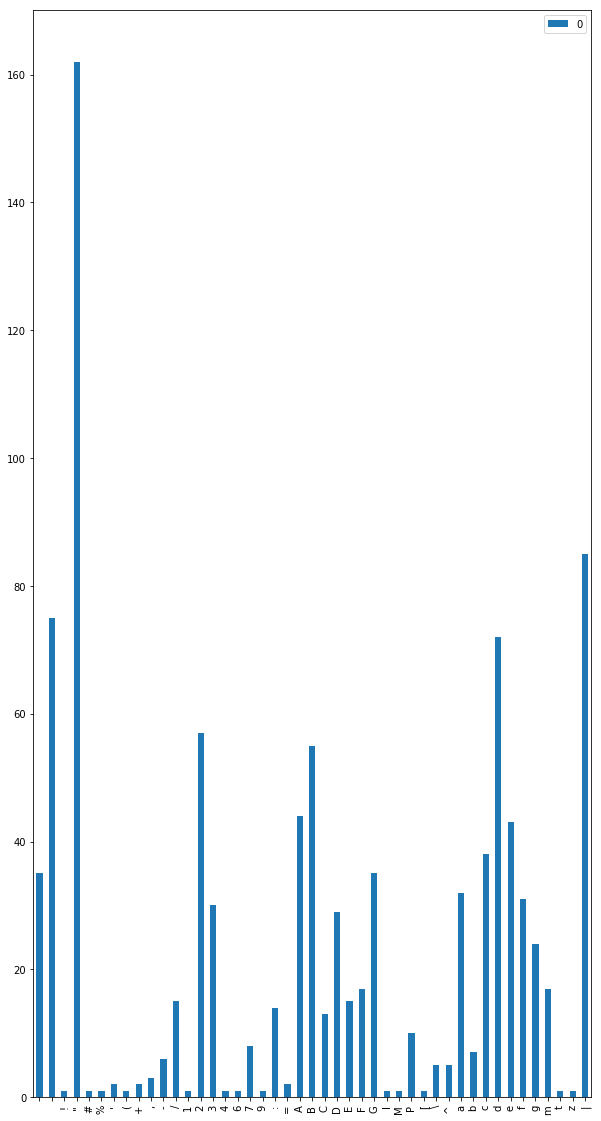

In [26]:
import pandas as pd
from collections import Counter
a = sorted(list(music_abc))
letter_counts = Counter(a)
df = pd.DataFrame.from_dict(letter_counts, orient='index')
df.plot(kind='bar', figsize=(10,20))

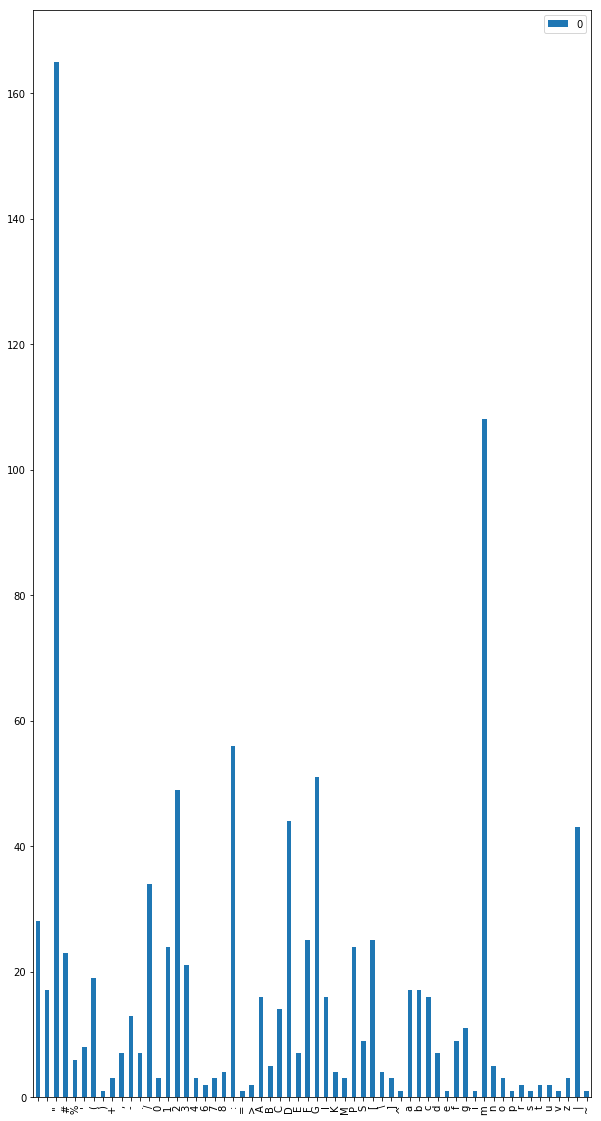

In [19]:
import pandas as pd
from collections import Counter
a = sorted(list(music_abc))
letter_counts = Counter(a)
df = pd.DataFrame.from_dict(letter_counts, orient='index')
df.plot(kind='bar', figsize=(10,20))

In [11]:
def idx_to_char(idx):
    return vocab_map['idx2char'][str(int(idx))]

vfunc = np.vectorize(idx_to_char)

In [12]:
text_map= vfunc(heatmap[0,:,0:100])

In [13]:
heatmap[1,:,0:1000][:4,:4]

array([[  9.99591887e-01,   9.99994397e-01,   6.59476280e-01,
          2.73013920e-01],
       [  9.99591887e-01,   9.99994397e-01,   6.59476280e-01,
          5.37013412e-01],
       [  1.89481623e-04,   2.59176750e-06,   3.33892822e-01,
          2.73013920e-01],
       [  1.72658300e-04,   8.15329713e-07,   4.36530728e-03,
          6.63040951e-02]])

/home/cseos2g/datduyn/.conda/envs/cs478project/lib/python3.6/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


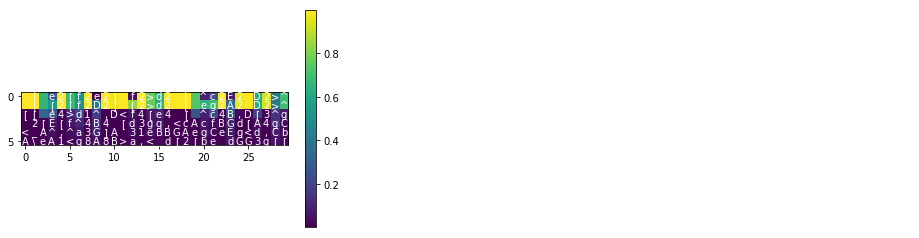

In [14]:
#https://matplotlib.org/gallery/images_contours_and_fields/image_annotated_heatmap.html
fig, ax = plt.subplots()
im = ax.imshow(heatmap[1,:,0:30])

# Loop over data dimensions and create text annotations.
for i in range(len(text_map)):
    for j in range(len(text_map[0])):
        text = ax.text(j, i, text_map[i, j],
                       ha="center", va="center", color="w")
# fig.colorbar(ax)
fig.colorbar(im,ax=ax)
fig.tight_layout()

In [154]:
heat_map[1]

array([[  5.98930180e-01,   6.99655414e-01,   9.98980939e-01,
          6.74393117e-01,   4.61797208e-01,   2.62753487e-01,
          7.37917781e-01,   9.84767139e-01,   2.62753487e-01,
          8.93393159e-01],
       [  9.20788348e-02,   2.06741422e-01,   2.28617093e-04,
          1.20498024e-01,   2.19840884e-01,   1.96328655e-01,
          2.03195214e-01,   4.51483112e-03,   1.96328655e-01,
          2.31623147e-02],
       [  5.88871650e-02,   3.22715864e-02,   1.66049082e-04,
          5.39283492e-02,   1.18779249e-01,   1.88566580e-01,
          2.05463115e-02,   3.28564504e-03,   1.88566580e-01,
          1.42358653e-02],
       [  5.53393178e-02,   3.03188227e-02,   9.80730038e-05,
          2.70178188e-02,   9.04975384e-02,   7.19026774e-02,
          1.64709259e-02,   2.77934317e-03,   7.19026774e-02,
          1.26095721e-02],
       [  3.86340655e-02,   1.29396087e-02,   9.12688774e-05,
          1.58256814e-02,   3.36676463e-02,   6.42791986e-02,
          1.52911050e-02

In [ ]:
out_soft

[ 0.00881344  0.00819033  0.01003748  0.01439313  0.01566641  0.02012172
  0.02670544  0.01429924  0.00817159  0.0243393   0.01808797  0.00786304
  0.02059154  0.00654612  0.01358718  0.01904634  0.00678441  0.01074101
  0.00991203  0.01018245  0.02273625  0.01028684  0.0168102   0.01229161
  0.01059775  0.00779227  0.01728607  0.00806514  0.02377261  0.00976335
  0.01870234  0.01534564  0.01961709  0.01604964  0.00974267  0.01735051
  0.03136642  0.02046453  0.01430773  0.01043758  0.0158743   0.01535269
  0.01675558  0.01484622  0.00879462  0.01782196  0.01018771  0.02304659
  0.01717358  0.00904324  0.00585431  0.02191257  0.01342308  0.00722929
  0.02692387  0.01162753  0.00651205  0.00807466  0.01137613  0.01136241
  0.02234575  0.00584393  0.0216484   0.01242542  0.01709915  0.05033881
  0.01023974]
[ 0.02316007  0.01488934  0.00380305  0.01023144  0.02200833  0.0071333
  0.00962085  0.00867375  0.04411287  0.00929209  0.02736273  0.00992851
  0.00402567  0.01422336  0.04081254  0.0120401   0.05193588  0.01331224
  0.02914766  0.00534466  0.0457323   0.00564058  0.04919361  0.02759544
  0.00616586  0.04105065  0.01936003  0.00687145  0.00368081  0.00510364
  0.01049835  0.00649755  0.00277873  0.00251447  0.01110584  0.01216636
  0.00242664  0.00095192  0.00866162  0.00846107  0.00206614  0.01816297
  0.02370209  0.006257    0.00408039  0.0126074   0.01218091  0.00544341
  0.01421754  0.01640938  0.00847971  0.00798011  0.00543279  0.00355627
  0.00132769  0.01281493  0.03602673  0.03887602  0.00417642  0.00482891
  0.02533414  0.01454004  0.02662339  0.00611772  0.00744368  0.03605494
  0.00774393]

In [9]:
#header info: http://trillian.mit.edu/~jc/music/abc/doc/ABCtut_Headers.html#I_Key
header = '''
X: 1
T:AbcRnn
% abcRnn
M:4/4
K:Cmin
'''

selected = '''
^D/2A/2B/2A/2A F2F/2G/2|
Aca aag|f/2a/2g/2f/2d/2 e3:|
\
A/2g/2f/2g/2|
f/2a3/2
e/2A/2 f/2g/2g/2f/2d/2^G/2|
"D"f2d/2d/2 "Bm"a3/2f/2a/2|"Em"g3 "E7/c+"e2d|"A7/c+"e2e "F/f+"d2c|"Bm"B2B A2^g|
"B7"a2f f2f|"E"g2e "B7"B2d|"B7"e2f g2g|"B7"a3 a2f|
"D7"d3 -c=cd|"G"B2G GBd|"C"e2e c2e|"Am"a3 "G7"g2d|"C"g3 z2:|
P:C


-----------------------------------------------------------------------------
_ef|"A"a^ag "D"fed|"F"ecA "G"Bcd|"Am"e3 -"D7"d2||
K:D
"D"AFA "G"Bcd|"D"Adf "G"gab|"D"agf def|"A7"edc A2a|"A7"afd e2c|
"D"d3 d2f|"D"A2f "A/e"c2e|"Bm"dcd "E7"e3|"A"cBc def|
"Bm"dfB BcB|"A"cde "E7"e2A|[1"A"A3 -A2||
 [2"A"A3 A2G/2F/2|E/2A/2e/2 "D"dcd|"A"e3 e2c|"A"A3 -A7||
K
K:D
"D"[2F2A "A"ABc|"Bm"d2d "D
'''

selected = '''
X:1
M:3/4
L:1/16
K:Bm
[D,2D,2D,,2]>D,2 D,2D,2 D,2D,2 | D,2>D,2 D,2D,2 D,2D,2 | D,2>D,2 D,2D,2 D,2D,2 | D,2>D,2 D,2D,2 D,2D,2 | [d2D,2D2A,2D,2A,,2D,,2]D,0[DD,] [D2D,2][D2D,2] [D2D,2][D2D,2] |
[D,2D2]D,0[DD,] [f2D2D,2][f2D2D,2] [d2D2D,2][f2D2D,2] | [g2D,2D2G,2G,,2]D,0[DD,] [D2D,2][D2D,2] [D2D,2][D2D,2] | [f2D,2D2A,2A,,2]D,0[DD,] [D2D,2][D2D,2] [D2D,2][D2D,2] | [d2D,2D2D2D,2D,2D,,2]D,0[DD,] [D2D,2][D2D,2] [D2D,2][D2D,2] |
[D,2D2]D,0[DD,] [f2D2D,2][f2D2D,2] [d2D2D,2][f2D2D,2] | [e2=C,2C2C2C,2]C,C,0[CC,] [C2C,2][C2C,2] [C2C,2][C2C,2] | [c2A,2A,,2A,2A,,2]>[A,2A,,2] [d2A,2A,,2][e2A,2A,,2] [A,2A,,2][A,2A,,2] | [f2D,2D2D2D,2D,2D,,2]D,D,0[DD,] [D2D,2][D2D,2] [D2D,2][D2D,2] |
[D,2D2]D,D,0[DD,] [d2D2D,2][f2D2D,2] [d2D2D,2][f2D2D,2] | [b2B,2B,,2G2G,2]>[B,2B,,2] [B,2B,,2][B,2B,,2] [B,2B,,2][B,2B,,2] | [a2F,2F,,2F2F,2]>[F,2F,,2] [F,2F,,2][G,2G,,2] [g2G,2G,,2][f2G,2G,,2] | [e2A,,2A,2E2D,2E,2D,,2]A,,A,,0[A,A,,] [A,2A,,2][A,2A,,2] [A,2A,,2][A,2A,,2] |
[A,2A,,2][A,2A,,2] [A,2A,,2][A,2A,,2] [A,2A,,2][A,2A,,2] | [d2G,,2G,2D2D,2]G,,G,,0[G,G,,] [G,2G,,2][G,2G,,2] [e2G,2G,,2][f2G,2G,,2] | [e2A,,2A,2E2E,2]A,,A,,0[A,A,,] [A,2A,,2][A,2A,,2] [A,2A,,2][A,2A,,2] | [G,,2G,2D2D,2D,2D,,2]G,,G,,0[G,G,,] [d2G,2G,,2][d2G,2G,,2] [e2G,2G,,2][f2G,2G,,2] |
[e2A,,2A,2C2C,2]A,,A,,0[A,A,,] [A,2A,,2][A,2A,,2] [A,2A,,2][d2A,2A,,2] | [d2D,2D2D2D,2]D,0[DD,] [D2D,2][D2D,2] [D2D,2][D2D,2] | [D,2D2]D,0[DD,] [D2D,2][D2D,2] [D2D,2][D2D,2] | [D,2D,2D,,2]>D,2 D,2D,2 D,2D,2 |
D,2>D,2 D,2D,2 D,2D,2 | D,2>D,2 D,2D,2 D,2D,2 | D,2>D,2 D,2D,2 D,2D,2 | [d2d2D2D,2D2A,2D,2A,,2D,,2d2]D,0[DD,] [D2D,2][D2D,2] [D2D,2][D2D,2] |
[D,2D2]D,0[DD,] [f2f2D2D,2f2][f2f2D2D,2] [d2d2D2D,2d2][f2f2D2D,2f2] | [g2g2A,2D,2D2G,2G,,2g2]D,0[DD,] [D2D,2][D2D,2] [D2D,2][D2D,2] | [f2f2A,2D,2D,2D2A,2A,,2f2]D,0[DD,] [D2D,2][D2D,2] [D2D,2][D2D,2] | [d2d2D,2D2D2D,2D,2D,,2d2]D,0[DD,] [D2D,2][D2D,2] [D2D,2][D2D,2] |
[D,2D2]D,0[DD,] [f2f2D2D,2f2][f2f2D2D,2] [d2d2D2D,2d2][f2f2D2D,2f2] | [e2e2=C,2C2C2C,2e2]C,C,0[CC,] [C2C,2][C2C,2] [C2C,2][C2C,2] | [c2c2A,2A,,2A,2A,,2c2]>[A,2A,,2] [d2d2A,2A,,2d2][e2e2A,2A,,2e2] [A,2A,,2][A,2A,,2] | [f2f2D2D,2D2d2D2D,2D,2D,,2f2]D,D,0[DD,] [D2D,2][E2D2D,2e2] [D2D,2][D2D,2] |
[F2D,2D2f2]D,D,0[DD,] [d2d2D2D,2d2][f2f2D2D2D,2d2f2] [d2d2D2D,2][f2f2D2D,2] | [b2b2G2B,2B,,2g2G2G,2b2]>[B,2B,,2] [B,2B,,2][B,2B,,2] [B,2B,,2][B,2B,,2] | [a2a2F2F,2F,,2f2F2F,2a2]>[F,2F,,2] [F,2F,,2][G,2G,,2] [g2g2A2G,2G,,2g2][f2f2F2G,2G,,2f2] | [e2e2E2A,,2A,2E2D,2E,2D,,2e2]A,,A,,0[A,A,,] [A,2A,,2][A,2A,,2] [A,2A,,2][A,2A,,2] |
[A,2A,,2][A,2A,,2] [A,2A,,2][A,2A,,2] [A,2A,,2][A,2A,,2] | [d2d2G,,2G,2D2D,2d2]G,,G,,0[G,G,,] [G,2G,,2][G,2G,,2] [e2e2G,2G,,2e2][f2f2G,2G,,2f2] | [e2e2A,,2A,2E2E,2e2]A,,A,,0[A,A,,] [A,2A,,2][A,2A,,2] [A,2A,,2][A,2A,,2] | [G,,2G,2D2D,2D,2D,,2]G,,G,,0[G,G,,] [d2d2G,2G,,2d2][d2d2G,2G,,2d2] [e2e2G,2G,,2e2][f2f2G,2G,,2f2] |
[e2e2A,,2A,2C2C,2e2]A,,A,,0[A,A,,] [A,2A,,2][A,2A,,2] [A,2A,,2][d2d2A,2A,,2d2] | [d2d2D,2D2D2D,2d2]D,0[DD,] [D2D,2][D2D,2] [D2D,2][D2D,2] | [D,2D2]D,0[DD,] [D2D,2][D2D,2] [D2D,2][D2D,2] | [d2A,2F,2d2D,2D,,2A2A,2F,2F2C2A,2E,2B,,2F,,2D,2D2d'2F2A,2D,2A,,2D,,2d2E,2]D,0[DD,] [F2C2A,2E,2B,,2F,,2D2D,2][D,2D,,2F2C2A,2E,2B,,2F,,2D2D,2] [F2C2A,2E,2B,,2F,,2D2D,2][D2D,2] |
[D,2D,,2F2C2A,2E,2B,,2F,,2D,2D2][F0C0A,0E,0B,,0F,,0]<D,0[DD,] [f2f2F2C2A,2E,2B,,2F,,2D2D,2f'2f2][f2D2A,2f2D,2D,,2d2D2A,2F2C2A,2E,2B,,2F,,2D2D,2] [d2d2D2D,2d'2d2][f2f2F2C2A,2E,2B,,2F,,2D2D,2f'2f2] | [g2D2B,2g2D2D,2D,,2A2D2B,2F2C2A,2E,2B,,2F,,2D,2D2g'2G2G,2G,,2g2]D,0[DD,] [F2C2A,2E,2B,,2F,,2D2D,2][D2D,2D,,2F2C2A,2E,2B,,2F,,2D2D,2] [F2C2A,2E,2B,,2F,,2D2D,2][D2D,2] | [f2D2A,2f2D2D,2D,,2F2D2A,2F2C2A,2E,2B,,2F,,2D,2D2f'2F2A,2A,,2f2][F0C0A,0E,0B,,0F,,0]<D,0[DD,] [F2C2A,2E,2B,,2F,,2D2D,2][D2D,2D,,2F2C2A,2E,2B,,2F,,2D2D,2] [D2D,2][F2C2A,2E,2B,,2F,,2D2D,2] | [d2A,2F,2d2A2D,2D,,2A2A,2F,2F2C2A,2E,2B,,2F,,2D,2D2d'2F2D2D,2D,2D,,2d2G,2E,2]D,0[DD,] [F2C2A,2E,2B,,2F,,2D2D,2][A2D,2D,,2F2C2A,2E,2B,,2F,,2D2D,2] [F2C2A,2E,2B,,2F,,2D2D,2][D2D,2] |
[A2D,2D,,2F2C2A,2E,2B,,2F,,2D,2D2][F0C0A,0E,0B,,0F,,0]<D,0[DD,] [f2f2F2C2A,2E,2B,,2F,,2D2D,2f'2f2][f2D2A,2f2A2D,2D,,2d2D2A,2F2C2A,2E,2B,,2F,,2D2D,2] [d2d2D2D,2d'2d2][f2f2F2C2A,2E,2B,,2F,,2D2D,2f'2f2] | [e2=C2G,2e2d2D,2D,,2A2C2G,2F2^C2A,2E,2B,,2F,,2=C,2C2e'2E2C2C,2e2]C,C,0[CC,] [F2^C2A,2E,2B,,2F,,2=C2C,2][c2D,2D,,2F2^C2A,2E,2B,,2F,,2=C2C,2] [F2^C2A,2E,2B,,2F,,2=C2C,2][C2C,2] | [c2A,2E,2c2B2D,2D,,2G2A,2E,2F2C2A,2E,2B,,2F,,2A,2A,,2c'2C2A,2A,,2c2][F2C2A,2E,2B,,2F,,2][A,A,,] [d2d2F2C2A,2E,2B,,2F,,2A,2A,,2d'2d2][e2C2A,2e2A2D,2D,,2F2C2A,2E,2B,,2F,,2A,2A,,2e'2e2] [A,2A,,2][F2C2A,2E,2B,,2F,,2A,2A,,2] | [f2D2A,2f2d2F2D,2D,,2F2D2A,2F2C2A,2E,2B,,2F,,2D,2D2f'2F2D2D,2D,2D,,2f2E,2]D,D,0[DD,] [F2C2A,2E,2B,,2F,,2D2D,2][d2F2D,2D,,2F2C2A,2E,2B,,2F,,2D2D,2] [F2C2A,2E,2B,,2F,,2D2D,2][D2D,2] |
[d2F2D,2D,,2F2C2A,2E,2B,,2F,,2D,2D2][F0C0A,0E,0B,,0F,,0D,0]<D,0[DD,] [d2d2F2C2A,2E,2B,,2F,,2D2D,2d'2d2][f2D2A,2f2d2F2D,2D,,2F2D2A,2F2C2A,2E,2B,,2F,,2D2D,2f'2f2] [d2d2D2D,2][f2f2F2C2A,2E,2B,,2F,,2D2D,2] | [b2F2D2b2e2G2D,2D,,2F2D2F2C2A,2E,2B,,2F,,2B,2B,,2b'2B2G2G,2b2]>[B,2B,,2] [F2C2A,2E,2B,,2F,,2B,2B,,2][d2G2D,2D,,2F2C2A,2E,2B,,2F,,2B,2B,,2] [F2C2A,2E,2B,,2F,,2B,2B,,2][B,2B,,2] | [a2F2C2a2a2F2D,2D,,2A2C2F2C2A,2E,2B,,2F,,2F,2F,,2a'2A2F2F,2a2][F2C2A,2E,2B,,2F,,2][F,F,,] [F2C2A,2E,2B,,2F,,2F,2F,,2][D2B,2d2F2D,2D,,2G2D2B,2F2C2A,2E,2B,,2F,,2G,2G,,2] [g2g2e2G,2G,,2g'2g2][f2f2c2F2C2A,2E,2B,,2F,,2G,2G,,2f'2f2] | [e2C2A,2e2d2A2D,2D,,2E2C2A,2F2C2A,2E,2B,,2F,,2A,,2A,2e'2e2E2D,2E,2D,,2e2C,2]A,,A,,0[A,A,,] [F2C2A,2E,2B,,2F,,2A,2A,,2][D,2D,,2F2C2A,2E,2B,,2F,,2A,2A,,2] [F2C2A,2E,2B,,2F,,2A,2A,,2][A,2A,,2] |
[D,2D,,2F2C2A,2E,2B,,2F,,2A,2A,,2][F2C2A,2E,2B,,2F,,2A,2A,,2] [F2C2A,2E,2B,,2F,,2A,2A,,2][D,2D,,2F2C2A,2E,2B,,2F,,2A,2A,,2] [A,2A,,2][F2C2A,2E,2B,,2F,,2A,2A,,2] | [d2B,2G,2d2a2d2D,2D,,2d2B,2G,2F2C2A,2E,2B,,2F,,2G,,2G,2d'2g2D2D,2d2]G,,G,,0[G,G,,] [F2C2A,2E,2B,,2F,,2G,2G,,2][D,2D,,2F2C2A,2E,2B,,2F,,2G,2G,,2] [e2e2F2C2A,2E,2B,,2F,,2G,2G,,2e'2e2][f2f2G,2G,,2f'2f2] | [e2C2A,2e2d2A2D,2D,,2e2C2A,2F2C2A,2E,2B,,2F,,2A,,2A,2e'2a2E2E,2e2][F0C0A,0E,0B,,0F,,0A,,0]<A,,0[A,A,,] [F2C2A,2E,2B,,2F,,2A,2A,,2][D,2D,,2F2C2A,2E,2B,,2F,,2A,2A,,2] [A,2A,,2][F2C2A,2E,2B,,2F,,2A,2A,,2] | [B,2G,2d2B,2G,2F2C2A,2E,2B,,2F,,2G,,2G,2f2D2D,2D,2D,,2]G,,G,,0[G,G,,] [d2d2F2C2A,2E,2B,,2F,,2G,2G,,2d'2d2][d2d2F2C2A,2E,2B,,2F,,2G,2G,,2d'2d2] [e2e2F2C2A,2E,2B,,2F,,2G,2G,,2e'2e2][f2f2G,2G,,2f'2f2] |
[e2C2A,2e2e2C2A,2F2C2A,2E,2B,,2F,,2A,,2A,2e'2e2C2C,2e2][F0C0A,0E,0B,,0F,,0A,,0]<A,,0[A,A,,] [F2C2A,2E,2B,,2F,,2A,2A,,2][F2C2A,2E,2B,,2F,,2A,2A,,2] [A,2A,,2][d2d2F2C2A,2E,2B,,2F,,2A,2A,,2d'2d2] | [d2d2d2D2A,2F2C2A,2E,2B,,2F,,2D,2D2d'2d2D2D,2d2]D,0[DD,] [F2C2A,2E,2B,,2F,,2D2D,2][F2C2A,2E,2B,,2F,,2D2D,2] [F2C2A,2E,2B,,2F,,2D2D,2][D2D,2] | [F2C2A,2E,2B,,2F,,2D,2D2][F0C0A,0E,0B,,0F,,0]<D,0[DD,] [F2C2A,2E,2B,,2F,,2D2D,2][F2C2A,2E,2B,,2F,,2D2D,2] [D2D,2][F2C2A,2E,2B,,2F,,2D2D,2] | [D,4D,4G4D,4G,4G4D,4]>[A4A4] [B4B4] |
[G4G4] [=C,4C,4G4C,4G4C,4]>[A4A4] | [B4B4] [G4G4] [B,,4B,,4G4B,,4G,4G4B,,4] | [A4A4] [B4B4] [e2e2][B2B2] | [E,8E,8d8E,8d8E,8] [A,,8A,,8A8D,8A8D,8] |
[=C,6A6C,6A6C,6][BB]c | =ccc2>G2G4< [A,,4A,,4A4A,,4] |[AB]B =ccc3G3G2 | [G,,6E6G,,6E6G,,6][GG][A4A4][D21D21] |
[=C12G,,12C12G,,12] | [D4D4] | [G,8G,8] [A,8A,8] | [A,,16A,,16A,,16] |
[G2G,,2G,2G,,2G,2G,,2G,,2][G14G,14] | [d4D,4d4F4D4D,4D,,4d4] [f4f4A4f4] [a6a6c6a6] |[g2g2B2g2] [g8g8B8F8g8] | [f8f8A8f8] [d4D,4d4F4G4D,4D,,4d4] |
[f4f4A4f4] [a4a4c4a4]>[g4g4B4g4] | [f16f16A16A16f16] | [d4D,4d4G4D4D,4D,,4d4] [g4g4B4g4] | [b4b4d4b4]>[a4a4d4a4] [a8a8c8B8a8] |
[g6g6B6g6][aaa][g2g2g2] | [f8D,8f8A8G8D,8D,,8f8] F8 | [d4d4F4d4d4] [f4f4B4f4] | [b4b4d4b4]>[a4a4c4a4] [a8D,8a8c8A8D,8D,,8a8] |
[g6g6B6g6][ggg][f2f2f2] | [e16e16A16E16e16] | [D,16D16D,16D,,16] | [d0D,0d0A0D0F,,0F0f0D0D,0D,0D,,0d0A0D0] B,,4 E,4 A,4 C4 |
[f4f4A4a4f4] [a4a4c4c'4a4]>[g4g4B4b4g4] | [g0g0F,,0B0b0F0F,0g0] B,,8 E,8 A,8 C8 [f8f8d8E8A8a8f8d8E8] | [d0D,0d0A0A,0F,,0F0f0G0D,0G,0D,,0d0A0D0] B,,4 E,4 A,4 C4 [f4f4A4a4f4] | [a4a4c4c'4a4]>[g4g4B4b4g4] [f16f16F16F,16F,,16A16a16A16A,16f16F16D16] B,,16 E,16 A,16 C16 |
[d0D,0d0D,0B,0F,,0G0g0D0D,0D,0D,,0d0] B,, E, A, CG,,D,[B,G,,] [ggD,Bbg]G,,[B,D,]G,, [bbD,dd'b]G,,D,G,, | [B,D,][B,G,,][a2a2D,2d2d'2a2]G,, [a0a0D,0A,0F,,0c0c'0B0B,0a0] B,, E, A, CG,,D,[A,G,,] D,G,,[A,D,]G,, | [ggD,Bbg]G,,D,G,, [A,D,][A,G,,][aaa]D,0[g2g2g2]G,, [f8D,8f8E8F,,8A8a8G8D,8G,8D,,8f8E,8] [A8B,,8] E,8 A,8 C8 | [F8F,8] |
[d0d0F,,0F0f0d0D0d0] B,,4 E,4 A,4 C4 [f4f4B4b4f4] [b6b6d6d'6b6] |[a2a2c2c'2a2] [a0D,0a0F,,0c0c'0A0D,0A,0D,,0a0] B,,8 E,8 A,8 C8 | [g6g6B6b6g6][ggg][f2f2f2] [e0e0F,,0A0a0E0E,0e0] B,,16 E,16 A,16 C16 | [D,16F,,16D16D,16D,16D,,16] B,,16 E,16 A,16 C16 |
[d2d2D,2d2D2D,2D2A,2D,2A,,2D,,2d2]D,0[DD,] [D2D,2][D2D,2] | [D2D,2][D2D,2] [D,2D2]D,0[DD,] [f2f2D2D,2f2][f2f2D2D,2] | [d2d2D2D,2d2][f2f2D2D,2f2] [g2G2D,2g2A,2D,2D2G,2G,,2g2]D,0[DD,] [D2D,2][D2D,2] | [D2D,2][D2D,2] [f2F2f2A,2D,2D,2D2A,2A,,2f2]D,0[DD,] [D2D,2][D2D,2] |
[D2D,2][D2D,2] [d2d2D,2d2D,2D2D2D,2D,2D,,2d2]D,0[DD,] [D2D,2][D2D,2] | [D2D,2][D2D,2] [D,2D2]D,0[DD,] [f2f2D2D,2f2][f2f2D2D,2] | [d2d2D2D,2d2][f2f2D2D,2f2] [eeG,,e=C,CCC,e]d[A0C,0]<C,0[CC,] [C2C,2][G2C2C,2] | [=C2C,2][C2C,2] [^c2c2A,2A,,2A,2A,,2c2]>[A,2A,,2] [d2d2A,2A,,2d2][e2F2D,2e2A,2A,,2e2] |
[A,2A,,2][A,2A,,2] [f2D,2f2D2D,2D2d2D2D,2D,2D,,2f2]D,D,0[DD,] [D2D,2][E2D2D,2e2] | [D2D,2][D2D,2] [F2D,2D2f2]D,D,0[DD,] [d2d2D2D,2d2][f2f2D2D2D,2d2f2] | [d2d2D2D,2][f2f2D2D,2] [b2b2G2B,2B,,2g2G2G,2b2]>[B,2B,,2] [B,2B,,2][B,2B,,2] | [B,2B,,2][B,2B,,2] [a2a2F2F,2F,,2f2F2F,2a2]>[F,2F,,2] [F,2F,,2][G,2G,,2] |
[g2g2A2G,2G,,2g2][f2f2F2G,2G,,2f2] [e2D,2e2E2A,,2A,2E2D,2E,2D,,2e2]A,,A,,0[A,A,,] [A,2A,,2][A,2A,,2] | [A,2A,,2][A,2A,,2] [A,2A,,2][A,2A,,2] [A,2A,,2][A,2A,,2] | [A,2A,,2][A,2A,,2] [d2d2G,,2G,2D2D,2d2]G,,G,,0[G,G,,] [G,2G,,2][G,2G,,2] | [e2e2G,2G,,2e2][f2f2G,2G,,2f2] [e2e2A,,2A,2E2E,2e2]A,,A,,0[A,A,,] [A,2A,,2][A,2A,,2] |
[A,2A,,2][A,2A,,2] [D,2G,,2G,2D2D,2D,2D,,2]G,,G,,0[G,G,,] [d2d2G,2G,,2d2][d2d2G,2G,,2d2] | [e2e2G,2G,,2e2][f2f2G,2G,,2f2] [e2e2A,,2A,2C2C,2e2]A,,A,,0[A,A,,] [A,2A,,2][A,2A,,2] | [A,2A,,2][d2d2A,2A,,2d2] [d2d2D,2D2D2D,2d2]D,0[DD,] [D2D,2][D2D,2] | [D2D,2][D2D,2] [D,2D2]D,0[DD,] [D2D,2][D2D,2] |
[D2D,2][D2D,2] [d2A,2F,2d2D,2D,,2A2A,2F,2F2C2A,2E,2B,,2F,,2D,2D2d'2F2A,2D,2A,,2D,,2d2E,2]D,0[DD,] [F2C2A,2E,2B,,2F,,2D2D,2][D,2D,,2F2C2A,2E,2B,,2F,,2D2D,2] | [F2C2A,2E,2B,,2F,,2D2D,2][D2D,2] [D,2D,,2F2C2A,2E,2B,,2F,,2D,2D2][F0C0A,0E,0B,,0F,,0]<D,0[DD,] [f2f2F2C2A,2E,2B,,2F,,2D2D,2f'2f2][f2D2A,2f2D,2D,,2d2D2A,2F2C2A,2E,2B,,2F,,2D2D,2] | [d2d2D2D,2d'2d2][f2f2F2C2A,2E,2B,,2F,,2D2D,2f'2f2] [g2D2B,2g2D2D,2D,,2A2D2B,2F2C2A,2E,2B,,2F,,2D,2D2g'2G2G,2G,,2g2]D,0[DD,] [F2C2A,2E,2B,,2F,,2D2D,2][D2D,2D,,2F2C2A,2E,2B,,2F,,2D2D,2] | [F2C2A,2E,2B,,2F,,2D2D,2][D2D,2] [f2D2A,2f2D2D,2D,,2F2D2A,2F2C2A,2E,2B,,2F,,2D,2D2f'2F2A,2A,,2f2][F0C0A,0E,0B,,0F,,0]<D,0[DD,] [F2C2A,2E,2B,,2F,,2D2D,2][D2D,2D,,2F2C2A,2E,2B,,2F,,2D2D,2] |
[D2D,2][F2C2A,2E,2B,,2F,,2D2D,2] [d2A,2F,2d2A2D,2D,,2A2A,2F,2F2C2A,2E,2B,,2F,,2D,2D2d'2F2D2D,2D,2D,,2d2G,2E,2]D,0[DD,] [F2C2A,2E,2B,,2F,,2D2D,2][A2D,2D,,2F2C2A,2E,2B,,2F,,2D2D,2] | [F2C2A,2E,2B,,2F,,2D2D,2][D2D,2] [A2D,2D,,2F2C2A,2E,2B,,2F,,2D,2D2][F0C0A,0E,0B,,0F,,0]<D,0[DD,] [f2f2F2C2A,2E,2B,,2F,,2D2D,2f'2f2][f2D2A,2f2A2D,2D,,2d2D2A,2F2C2A,2E,2B,,2F,,2D2D,2] | [d2d2D2D,2d'2d2][f2f2F2C2A,2E,2B,,2F,,2D2D,2f'2f2] [e2=C2G,2e2d2D,2D,,2A2C2G,2F2^C2A,2E,2B,,2F,,2=C,2C2e'2E2C2C,2e2]C,C,0[CC,] [F2^C2A,2E,2B,,2F,,2=C2C,2][c2D,2D,,2F2^C2A,2E,2B,,2F,,2=C2C,2] | [F2C2A,2E,2B,,2F,,2=C2C,2][C2C,2] [^c2A,2E,2c2B2D,2D,,2G2A,2E,2F2C2A,2E,2B,,2F,,2A,2A,,2c'2C2A,2A,,2c2][F2C2A,2E,2B,,2F,,2][A,A,,] [d2d2F2C2A,2E,2B,,2F,,2A,2A,,2d'2d2][e2C2A,2e2A2D,2D,,2F2C2A,2E,2B,,2F,,2A,2A,,2e'2e2] |
[A,2A,,2][F2C2A,2E,2B,,2F,,2A,2A,,2] [f2D2A,2f2d2F2D,2D,,2F2D2A,2F2C2A,2E,2B,,2F,,2D,2D2f'2F2D2D,2D,2D,,2f2E,2]D,D,0[DD,] [F2C2A,2E,2B,,2F,,2D2D,2][d2F2D,2D,,2F2C2A,2E,2B,,2F,,2D2D,2] | [F2C2A,2E,2B,,2F,,2D2D,2][D2D,2] [d2F2D,2D,,2F2C2A,2E,2B,,2F,,2D,2D2][F0C0A,0E,0B,,0F,,0D,0]<D,0[DD,] [d2d2F2C2A,2E,2B,,2F,,2D2D,2d'2d2][f2D2A,2f2d2F2D,2D,,2F2D2A,2F2C2A,2E,2B,,2F,,2D2D,2f'2f2] | [d2d2D2D,2][f2f2F2C2A,2E,2B,,2F,,2D2D,2] [b2F2D2b2e2G2D,2D,,2F2D2F2C2A,2E,2B,,2F,,2B,2B,,2b'2B2G2G,2b2]>[B,2B,,2] [F2C2A,2E,2B,,2F,,2B,2B,,2][d2G2D,2D,,2F2C2A,2E,2B,,2F,,2B,2B,,2] | [F2C2A,2E,2B,,2F,,2B,2B,,2][B,2B,,2] [a2F2C2a2a2F2D,2D,,2A2C2F2C2A,2E,2B,,2F,,2F,2F,,2a'2A2F2F,2a2][F2C2A,2E,2B,,2F,,2][F,F,,] [F2C2A,2E,2B,,2F,,2F,2F,,2][D2B,2d2F2D,2D,,2G2D2B,2F2C2A,2E,2B,,2F,,2G,2G,,2] |
[g2g2e2G,2G,,2g'2g2][f2f2c2F2C2A,2E,2B,,2F,,2G,2G,,2f'2f2] [e2C2A,2e2d2A2D,2D,,2E2C2A,2F2C2A,2E,2B,,2F,,2A,,2A,2e'2e2E2D,2E,2D,,2e2C,2]A,,A,,0[A,A,,] [F2C2A,2E,2B,,2F,,2A,2A,,2][D,2D,,2F2C2A,2E,2B,,2F,,2A,2A,,2] | [F2C2A,2E,2B,,2F,,2A,2A,,2][A,2A,,2] [D,2D,,2F2C2A,2E,2B,,2F,,2A,2A,,2][F2C2A,2E,2B,,2F,,2A,2A,,2] [F2C2A,2E,2B,,2F,,2A,2A,,2][D,2D,,2F2C2A,2E,2B,,2F,,2A,2A,,2] | [A,2A,,2][F2C2A,2E,2B,,2F,,2A,2A,,2] [d2B,2G,2d2a2d2D,2D,,2d2B,2G,2F2C2A,2E,2B,,2F,,2G,,2G,2d'2g2D2D,2d2]G,,G,,0[G,G,,] [F2C2A,2E,2B,,2F,,2G,2G,,2][D,2D,,2F2C2A,2E,2B,,2F,,2G,2G,,2] | [e2e2F2C2A,2E,2B,,2F,,2G,2G,,2e'2e2][f2f2G,2G,,2f'2f2] [e2C2A,2e2d2A2D,2D,,2e2C2A,2F2C2A,2E,2B,,2F,,2A,,2A,2e'2a2E2E,2e2][F0C0A,0E,0B,,0F,,0A,,0]<A,,0[A,A,,] [F2C2A,2E,2B,,2F,,2A,2A,,2][D,2D,,2F2C2A,2E,2B,,2F,,2A,2A,,2] |
[A,2A,,2][F2C2A,2E,2B,,2F,,2A,2A,,2] [B,2G,2d2B,2G,2F2C2A,2E,2B,,2F,,2G,,2G,2f2D2D,2D,2D,,2]G,,G,,0[G,G,,] [d2d2F2C2A,2E,2B,,2F,,2G,2G,,2d'2d2][d2d2F2C2A,2E,2B,,2F,,2G,2G,,2d'2d2] | [e2e2F2C2A,2E,2B,,2F,,2G,2G,,2e'2e2][f2f2G,2G,,2f'2f2] [e2C2A,2e2e2C2A,2F2C2A,2E,2B,,2F,,2A,,2A,2e'2e2C2C,2e2][F0C0A,0E,0B,,0F,,0A,,0]<A,,0[A,A,,] [F2C2A,2E,2B,,2F,,2A,2A,,2][F2C2A,2E,2B,,2F,,2A,2A,,2] | [A,2A,,2][d2d2F2C2A,2E,2B,,2F,,2A,2A,,2d'2d2] [d2d2d2D2A,2F2C2A,2E,2B,,2F,,2D,2D2d'2d2D2D,2d2]D,0[DD,] [F2C2A,2E,2B,,2F,,2D2D,2][F2C2A,2E,2B,,2F,,2D2D,2] | [F2C2A,2E,2B,,2F,,2D2D,2][D2D,2] [F2C2A,2E,2B,,2F,,2D,2D2][F0C0A,0E,0B,,0F,,0]<D,0[DD,] [F2C2A,2E,2B,,2F,,2D2D,2][F2C2A,2E,2B,,2F,,2D2D,2] |
[D2D,2][F2C2A,2E,2B,,2F,,2D2D,2] F,,24 B,,24 E,24 A,24 C24 F24 |
'''



music_abc = header + music_abc

In [15]:
music_abc = '''
X: 1
T: Cooley's
M: 4/4
R: reel
K: Cmin
[D2D,2F,2A,2]F2A23/2A/22B2D,2G,2B,2]B2|A2D,2F,2A,2]F2D2B,,2F,2A,2]F2A23/2A/22|G2B,,2D,2G,2]F2E4A,,4C,4E,4]D2A,,2D,2F,2]F2|A4D2F,,2B,,2D,2]3/2F/22E2G,,2B,,2D,2]D2|C2E,,2A,,2C,2]A,2D2A,,2D,2F,2]F2A23/2E/22|
GA,,E,A,]GF2D16D,16F,16A,16]|D2D,2]F2F,2A,2]|A2F,2A,2]AB2D,2]B2G,2B,2]A2D,2]F2F,2A,2]|D2B,,2]F2D,2F,2]A2D,2F,2]AG2B,,2]F2D,2G,2]|
E2A,,2]C,2E,2]D2D,2]F2F,2A,2]A2F,2A,2]|D2B,,2]D,2F,2]FE2G,,2]D2D,2G,2]C2A,,2]A,2C,2E,2]|D2D,2]F2F,2A,2]A2F,2A,2]EGA,,]GF2E,2A,2]|D,2D2]F,4A,4]F,2A,2]D,2F,4A,4]|
F,2A,2]D2D,2F,2A,2]F2A23/2A/22|B2D,2G,2B,2]B2A2D,2F,2A,2]F2D2B,,2F,2A,2]F2|A23/2A/22G2B,,2D,2G,2]F2E4A,,4C,4E,4]|D2A,,2D,2F,2]F2A4D2F,,2B,,2D,2]3/2F/22|
E2G,,2B,,2D,2]D2C2E,,2A,,2C,2]A,2D2A,,2D,2F,2]F2|A23/2E/22GA,,E,A[GF2D16D,16F,16A,16]
'''

'''

[dD,]FddDd| [dDD,Ff]f [ddD]dB [d^Gd]B[A_C,] | [D2F2c2][F2D,2D,2]=c2 |
[ebE]c[_ge][d'4c4e4d'4d4G4 D4g4g4G4C4 |
G2 [e'4E4C,4e4] | [c'4B4]c2 d4 a4 |
d f4=e' [c'^AeE]bG | [D,E]cF[a']A[adf] | [a'GFC,]c'b[g'e']B,[dfGB,] | [Eeg][Bb'eeE]<[bFfFB,,,,]ed[aAB,,] [ga][a0G0b0] [d4D,,,,4] [a0e0B0]<G0 [^C0D0G0d0B,
'''

"\n\n[dD,]FddDd| [dDD,Ff]f [ddD]dB [d^Gd]B[A_C,] | [D2F2c2][F2D,2D,2]=c2 |\n[ebE]c[_ge][d'4c4e4d'4d4G4 D4g4g4G4C4 |\nG2 [e'4E4C,4e4] | [c'4B4]c2 d4 a4 |\nd f4=e' [c'^AeE]bG | [D,E]cF[a']A[adf] | [a'GFC,]c'b[g'e']B,[dfGB,] | [Eeg][Bb'eeE]<[bFfFB,,,,]ed[aAB,,] [ga][a0G0b0] [d4D,,,,4] [a0e0B0]<G0 [^C0D0G0d0B,\n"

- remove #
- bracket linter
- invalid: `[d4c'C4A,4C,4f4f4A4A,4,C4]`. no note in chord after number and closing `]`
- after `[` cannot start with a number
- syntax: http://abcnotation.com/wiki/abc:standard:v2.1

In [10]:
print(music_abc)


X: 1
T:AbcRnn
% abcRnn
M:4/4
K:Cmin
FG,D][ADd][^cc][C,,_E,,^c][cE] [C2^D2a2A2D,2f2][D,,D,DE,,][EGA,]^F,, | [G,^D,E,,]GE[^aD^D,DD,F][ACE,^E,] [G,,aA,f] [G,,E][DG]F[FA,DD][DG,][A,G,] [CD,,] F,[B,2E2e2][^F,GF,,G,][B,BC,,g][DB,,,AgD] | ^D3[c2C2E2C2G2][D,,C,,] A,, [D2G,2][cF,]B, C2[D2D2]C[C2G2]E [A,2F,2]G2 | [A,2^C2F2C,,2g2F2F,2^D2D2d2][C2F,2] [A,c]FA[G^F,,g]F | [G,Ec]F,[^F,,2C2] [D2G2][A,2D2] F,,2[C2G2] | [c4D,4] A[A,,2c2] | G,,2F,,2 F,,2[G,2E2] | [_BC,d] F4 [E2G,2][D2G2] [F^FB,,A,]G2 F,F,,2C |
[E,2A2E2] F,,2E,,2 [^F,,2^F,2]B,,2 [A,2D2B,,2D2B2F,,2B2]B2 [F,4E,,4] c4 | [G,,2B2][B2d2] [^F,,2c2]B2 [G2B2c2][E,2F2] |
[d2^F2B,,2c2F2d2B2]f2 [B,,,4B,,,4] [^F,B,GdfDF] B,2B,2 [_eeBFGB,]< [CEB,,,] cee |Be2 G< [BE] [C,,C,,dg] B2 ^C,2GF,2g C,, f2 [d15B,,,15]CG,,,8 | [G4B4A,4B4C,,4]>B,4 B4 F4 F4 | c2c2 [B,D,]d2 f4 | [F2c2D2F,,2]d2 [F2D2D2d2]c2 G,,4 | d4 B4 [B2B,2G2^D2D,2d2]e2 | [EgF,F,,] egF5 [G,B,EgG]BFA a [aFG,G,]af13 |g5 f3 |
f6df4 |B2 [F2B,2D,2]>G2 | [BG,D,]AB2 [B,G,B,]G D,D2B [B3D3F,3]G3 |D3 D3F2D 

In [11]:
from music21 import *
abcScore = converter.parse(music_abc, format='abc')
mf = midi.translate.streamToMidiFile(abcScore)
mf.open('./midi_epoch20-03.mid', 'wb')
mf.write()
mf.close()